<a href="https://colab.research.google.com/github/gmfv/Prediccion_Temperatura_IA/blob/main/RedRecurrente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split

from keras.layers import LSTM, Input, Dense
from keras.models import Model

#from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
#from bitstring import BitArray
from sklearn.preprocessing import MinMaxScaler

np.random.seed(1120)

In [4]:
def prepare_dataset(data, window_size):
    X, Y = np.empty((0,window_size)), np.empty((0))
    for i in range(len(data)-window_size-1):
        X = np.vstack([X,data[i:(i + window_size),0]])
        Y = np.append(Y,data[i + window_size,0])   
    X = np.reshape(X,(len(X),window_size,1))
    Y = np.reshape(Y,(len(Y),1))
    return X, Y

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/gmfv/Prediccion_Temperatura_IA/main/temperatura.csv')

pred = 2 #Por ser 24 horas del dia
#df = load_dataset('https://raw.githubusercontent.com/gmfv/Prediccion_Temperatura_IA/main/temperatura.csv')
df["Dia"]=df['date'].apply(lambda x: int(x.split()[0].split('-')[2]))
df["Mes"]=df['date'].apply(lambda x: int(x.split()[0].split('-')[1]))
df["Año"]=df['date'].apply(lambda x: int(x.split()[0].split('-')[0]))
df["Hora"]=df['date'].apply(lambda x: int(x.split()[1].split(':')[0]))
df["temp_t1"] = df["Temperatura Asuncion"].shift(periods=-pred)
df["Year_t1"] = df["Año"].shift(periods=-pred)
df["Hour_t1"] = df["Hora"].shift(periods=-pred)
df["Month_t1"] = df["Mes"].shift(periods=-pred)
df["Weekday_t1"] = df["Dia"].shift(periods=-pred)
df = df.dropna()
#df.drop(columns='date',inplace=True)
df=df.set_index("date")
df=df[df['Hora']%2 == 0]
#data["Temperatura Asuncion"]

In [ ]:
data1

array([26.76923077, 24.21538462, 23.00769231, ..., 32.9       ,
       34.        , 35.1       ])

In [6]:
data1 = df["Temperatura Asuncion"].values
scaler = MinMaxScaler(feature_range=(0, 1))
data1 = scaler.fit_transform(np.reshape(data1, [-1,1]))
#data2 = scaler.fit_transform(data2)

In [7]:
df["Temperatura Asuncion"]=data1
#df["temp_t1"]=data2

In [8]:
train_data = df[['Temperatura Asuncion']].values[0:round(len(df)*0.8)]
test_data = df[['Temperatura Asuncion']].values[round(len(df)*0.8)+1:-1]

In [9]:
best_window_size=60
best_num_units=9

In [10]:
X_train,y_train = prepare_dataset(train_data,best_window_size)
X_test, y_test = prepare_dataset(test_data,best_window_size)

inputs = Input(shape=(best_window_size,1))
x = LSTM(best_num_units, input_shape=(best_window_size,1))(inputs)
predictions = Dense(1, activation='linear')(x)
model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer='adam',loss='mean_squared_error')
history=model.fit(X_train, y_train, epochs=35, batch_size=24, validation_data=(X_test, y_test), shuffle=True)
y_pred = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: ', rmse)

Epoch 1/35
1310/1310 [==============================] - 41s 19ms/step - loss: 0.0540 - val_loss: 0.0078
Epoch 2/35
1310/1310 [==============================] - 25s 19ms/step - loss: 0.0067 - val_loss: 0.0029
Epoch 3/35
1310/1310 [==============================] - 24s 19ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 4/35
1310/1310 [==============================] - 24s 19ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 5/35
1310/1310 [==============================] - 24s 18ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 6/35
1310/1310 [==============================] - 24s 18ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 7/35
1310/1310 [==============================] - 24s 19ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 8/35
1310/1310 [==============================] - 24s 18ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 9/35
1310/1310 [==============================] - 24s 18ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 10/35
1310/1310 [==============================] - 24s 18m

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 9)                 396       
_________________________________________________________________
dense (Dense)                (None, 1)                 10        
Total params: 406
Trainable params: 406
Non-trainable params: 0
_________________________________________________________________


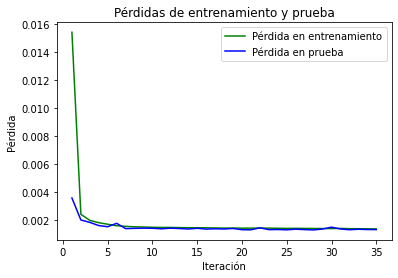

In [ ]:
import matplotlib.pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,36)
plt.plot(epochs, loss_train, 'g', label='Pérdida en entrenamiento')
plt.plot(epochs, loss_val, 'b', label='Pérdida en prueba')
plt.title('Pérdidas de entrenamiento y prueba')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
y_test

array([[23.2       ],
       [22.8388343 ],
       [24.12693318],
       ...,
       [29.9       ],
       [31.5       ],
       [32.9       ]])


Máxima diferencia:  [12.70874863] , Media:  0.11476521996243934


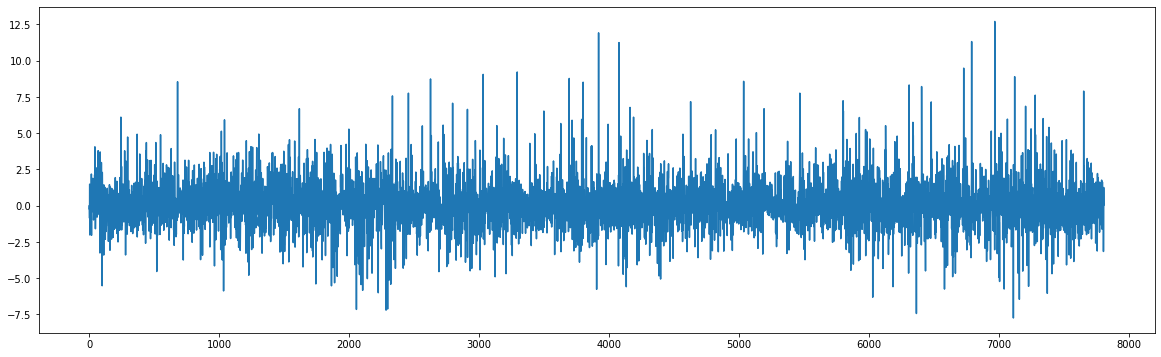

In [ ]:
plt.figure(figsize= (20,6))
plt.plot(linewidth=0.2)
gradosdif=y_pred-y_test
plt.plot(gradosdif)
print('\nMáxima diferencia: ', max(np.abs(gradosdif)), ', Media: ', np.mean(gradosdif))

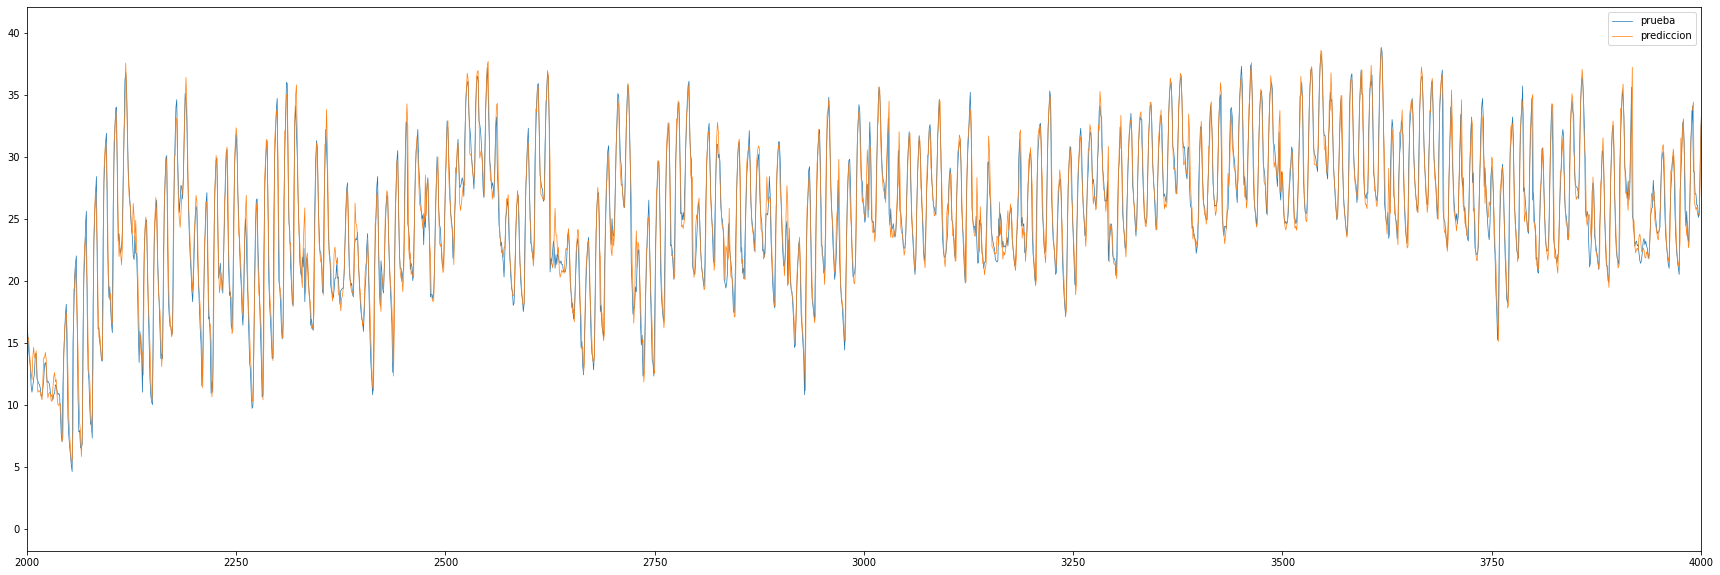

In [ ]:
grafico=pd.DataFrame()
grafico['prueba']= y_test.reshape(len(y_test))
grafico['prediccion']= y_pred
grafico.plot(linewidth=0.7).set_xlim([2000, 4000])
plt.gcf().set_size_inches(30, 10)

In [ ]:
TemperaturasAnhos= df [['Temperatura Asuncion','Año']]

In [ ]:
Temperatura2009= TemperaturasAnhos.loc[TemperaturasAnhos['Año']==2009, "Temperatura Asuncion"].values
Temperatura2010= TemperaturasAnhos.loc[TemperaturasAnhos['Año']==2010, "Temperatura Asuncion"].values
Temperatura2011= TemperaturasAnhos.loc[TemperaturasAnhos['Año']==2011, "Temperatura Asuncion"].values
Temperatura2012= TemperaturasAnhos.loc[TemperaturasAnhos['Año']==2012, "Temperatura Asuncion"].values
Temperatura2013= TemperaturasAnhos.loc[TemperaturasAnhos['Año']==2013, "Temperatura Asuncion"].values
Temperatura2014= TemperaturasAnhos.loc[TemperaturasAnhos['Año']==2014, "Temperatura Asuncion"].values
Temperatura2015= TemperaturasAnhos.loc[TemperaturasAnhos['Año']==2015, "Temperatura Asuncion"].values
Temperatura2016= TemperaturasAnhos.loc[TemperaturasAnhos['Año']==2016, "Temperatura Asuncion"].values
Temperatura2017= TemperaturasAnhos.loc[TemperaturasAnhos['Año']==2017, "Temperatura Asuncion"].values

In [ ]:
Temperatura2009

array([0.64488424, 0.58289768, 0.55358476, ..., 0.75093353, 0.76792382,
       0.70145631])

In [ ]:
y_pred2009 = scaler.inverse_transform(model.predict(Temperatura2009))
y_pred2010 = scaler.inverse_transform(model.predict(Temperatura2010))
y_pred2011 = scaler.inverse_transform(model.predict(Temperatura2011))
y_pred2012 = scaler.inverse_transform(model.predict(Temperatura2012))
y_pred2013 = scaler.inverse_transform(model.predict(Temperatura2013))
y_pred2014 = scaler.inverse_transform(model.predict(Temperatura2014))
y_pred2015 = scaler.inverse_transform(model.predict(Temperatura2015))
y_pred2016 = scaler.inverse_transform(model.predict(Temperatura2016))
y_pred2017 = scaler.inverse_transform(model.predict(Temperatura2017))

In [ ]:
y_pred2009

array([[23.292612],
       [21.317896],
       [20.370815],
       ...,
       [26.564734],
       [27.074903],
       [25.056293]], dtype=float32)

In [ ]:
Temperatura2009

array([0.64488424, 0.58289768, 0.55358476, ..., 0.75093353, 0.76792382,
       0.70145631])

In [ ]:
Temperatura2009=scaler.inverse_transform(np.reshape(Temperatura2009, [-1,1]))
Temperatura2010=scaler.inverse_transform(np.reshape(Temperatura2010, [-1,1]))
Temperatura2011=scaler.inverse_transform(np.reshape(Temperatura2011, [-1,1]))
Temperatura2012=scaler.inverse_transform(np.reshape(Temperatura2012, [-1,1]))
Temperatura2013=scaler.inverse_transform(np.reshape(Temperatura2013, [-1,1]))
Temperatura2014=scaler.inverse_transform(np.reshape(Temperatura2014, [-1,1]))
Temperatura2015=scaler.inverse_transform(np.reshape(Temperatura2015, [-1,1]))
Temperatura2016=scaler.inverse_transform(np.reshape(Temperatura2016, [-1,1]))
Temperatura2017=scaler.inverse_transform(np.reshape(Temperatura2017, [-1,1]))

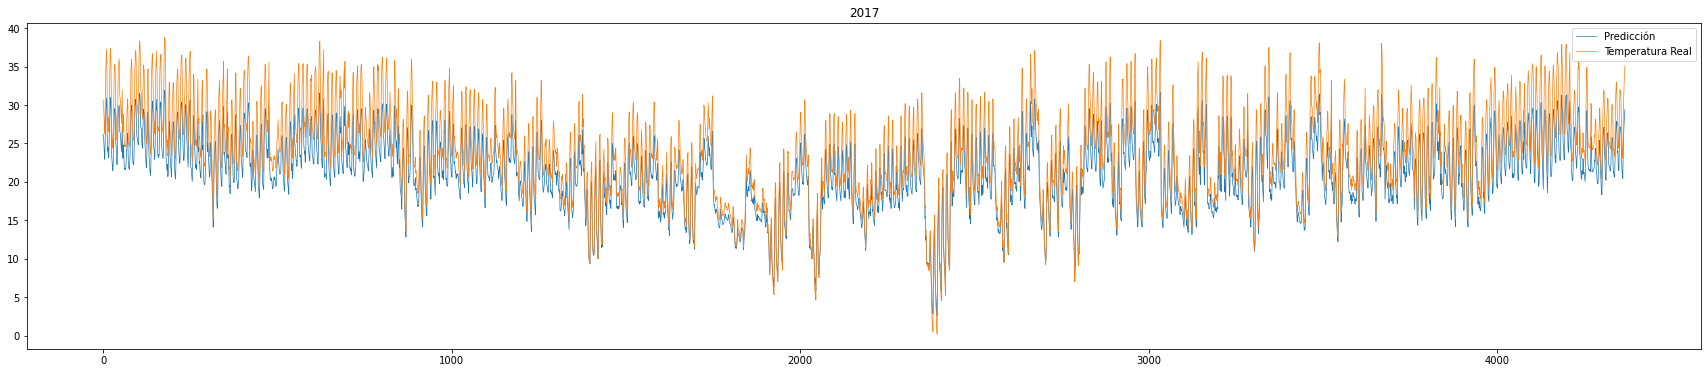

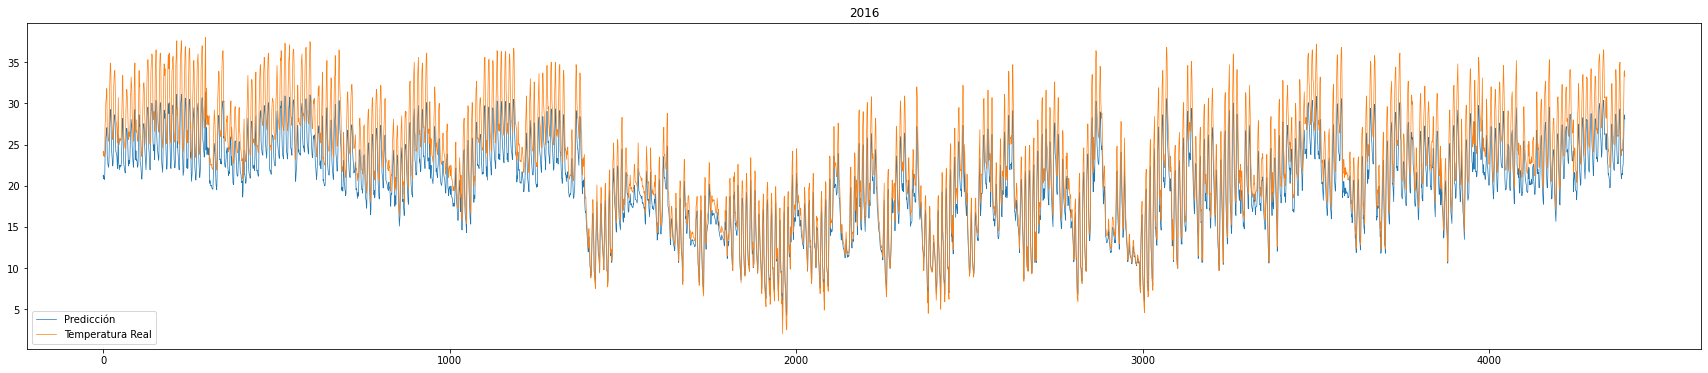

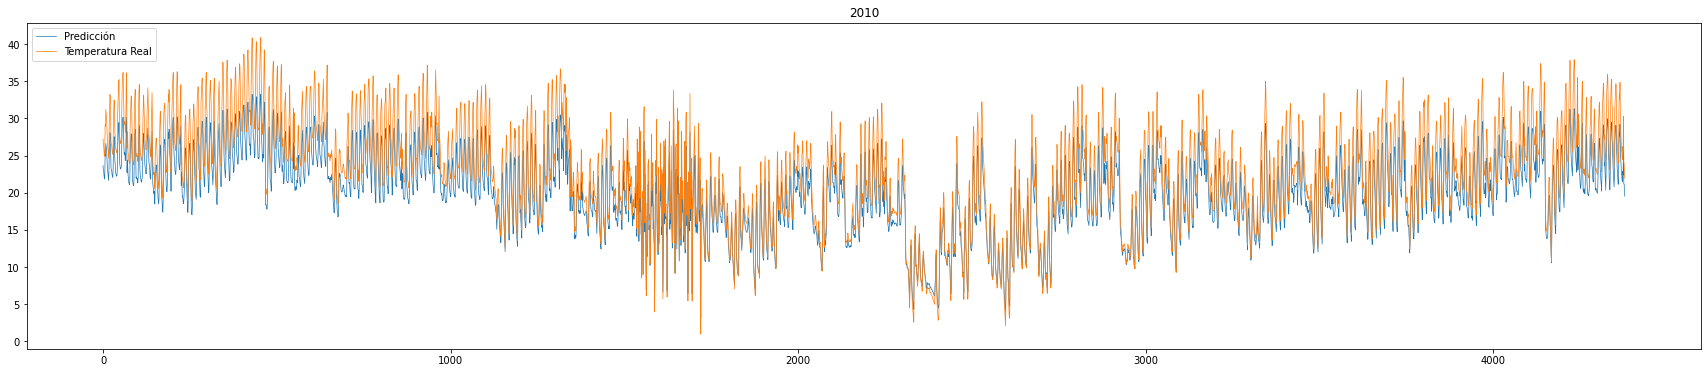

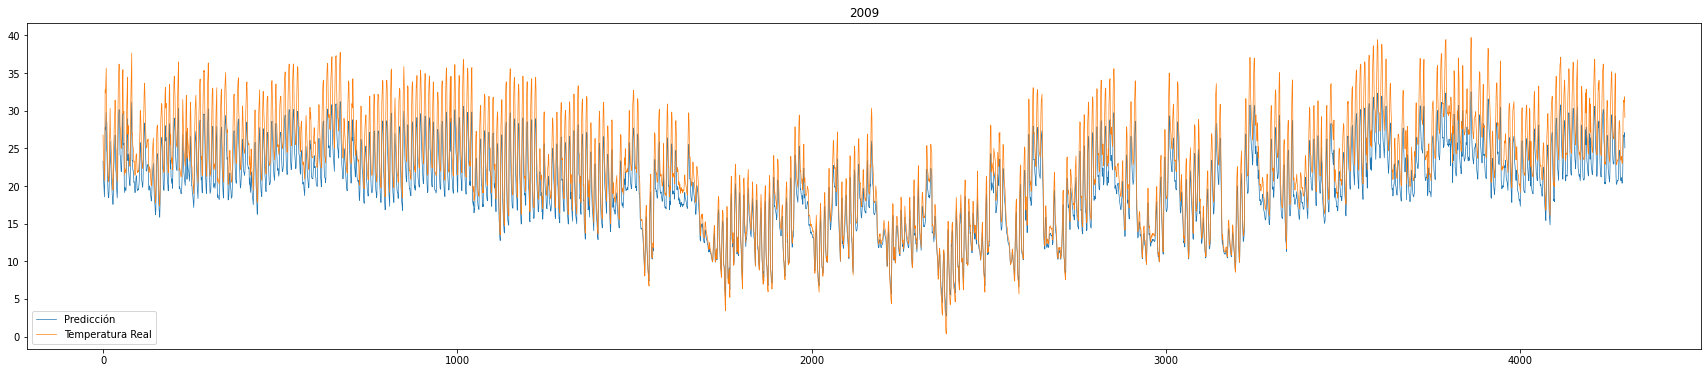

In [ ]:
plt.figure(figsize= (30,6))
plt.title('2017')
plt.plot(y_pred2017, label='Predicción', linewidth=0.7)
plt.plot(Temperatura2017, label='Temperatura Real', linewidth=0.7)
plt.legend()
plt.show()
plt.figure(figsize= (30,6))
plt.title('2016')
plt.plot(y_pred2016, label='Predicción', linewidth=0.7)
plt.plot(Temperatura2016, label='Temperatura Real', linewidth=0.7)
plt.legend()
plt.show()
plt.figure(figsize= (30,6))
plt.title('2010')
plt.plot(y_pred2010, label='Predicción', linewidth=0.7)
plt.plot(Temperatura2010, label='Temperatura Real', linewidth=0.7)
plt.legend()
plt.show()
plt.figure(figsize= (30,6))
plt.title('2009')
plt.plot(y_pred2009, label='Predicción', linewidth=0.7)
plt.plot(Temperatura2009, label='Temperatura Real', linewidth=0.7)
plt.legend()
plt.show()

2009

Máxima diferencia:  [7.20201598] , Media:  -2.6659857783057888
2010

Máxima diferencia:  [7.60636902] , Media:  -2.68416358224772
2011

Máxima diferencia:  [7.36791534] , Media:  -2.682861168549844
2012

Máxima diferencia:  [7.45572968] , Media:  -2.9396212036590375
2013

Máxima diferencia:  [7.6569636] , Media:  -2.7519168437506667
2014

Máxima diferencia:  [7.79480591] , Media:  -2.9544430147515097
2015

Máxima diferencia:  [6.89719395] , Media:  -2.966072457673302
2016

Máxima diferencia:  [6.62041855] , Media:  -2.7276287284549805
2017

Máxima diferencia:  [6.88698463] , Media:  -2.961152757558217


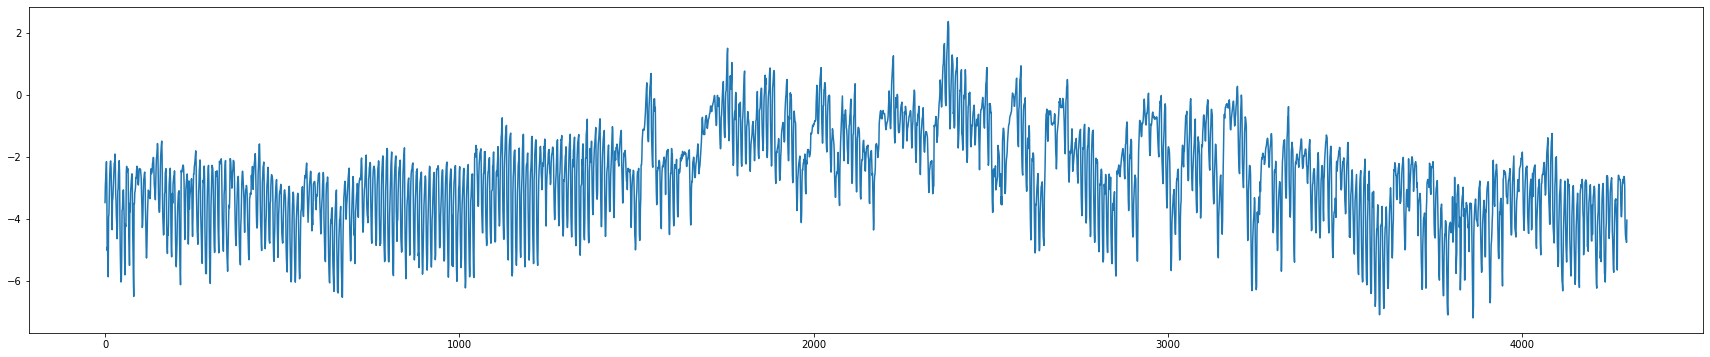

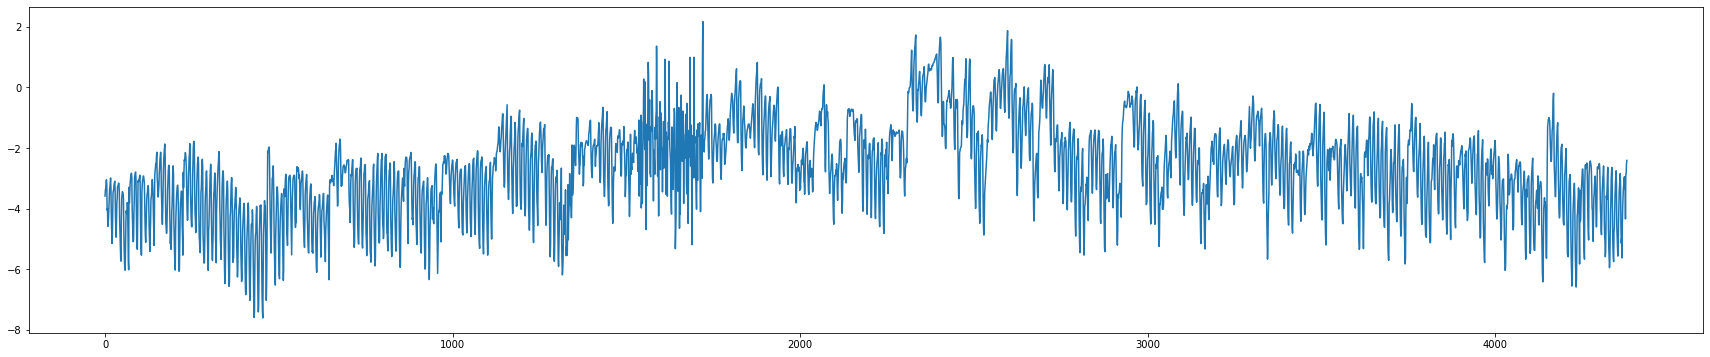

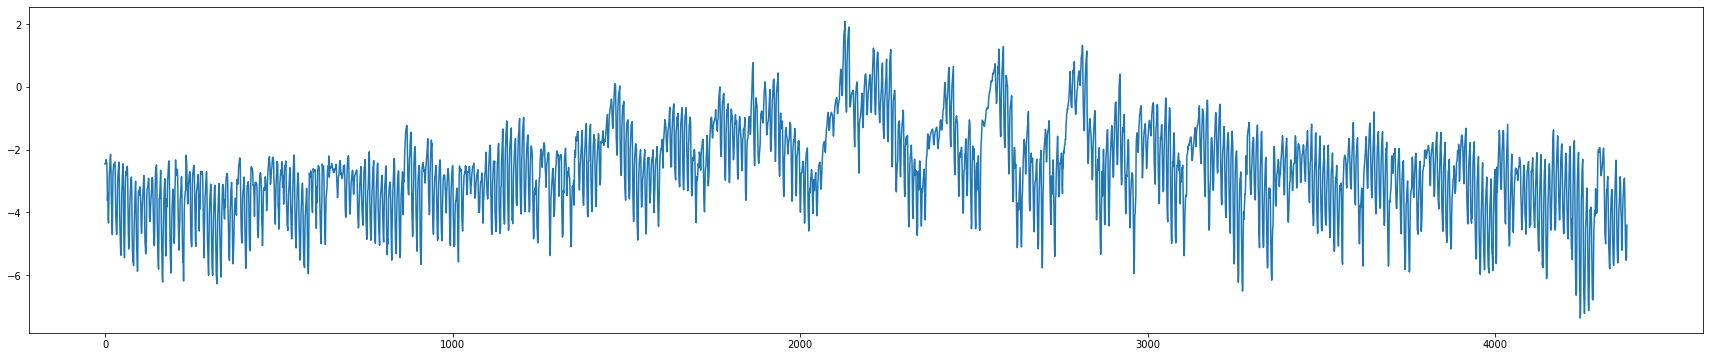

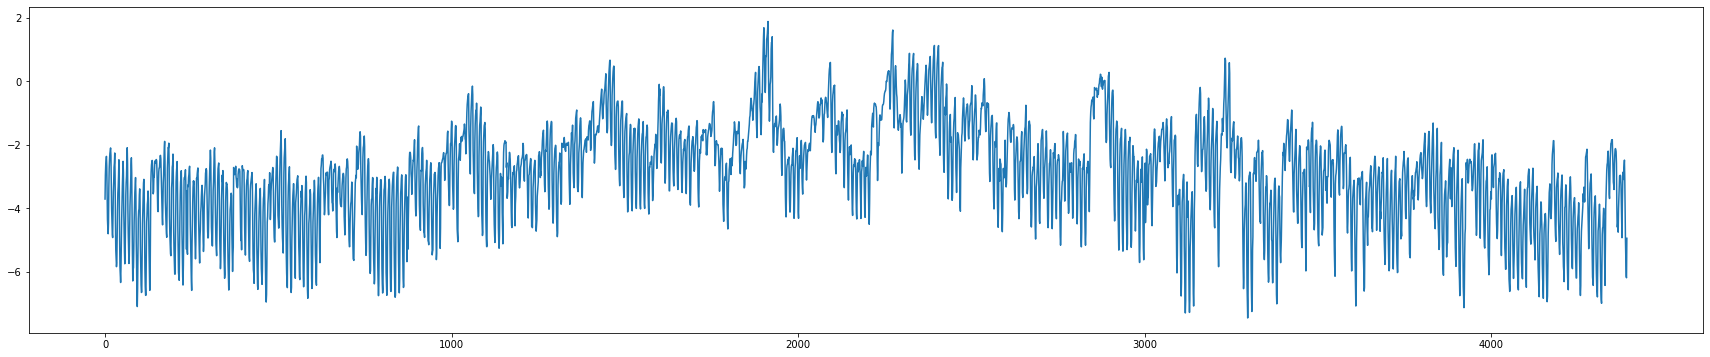

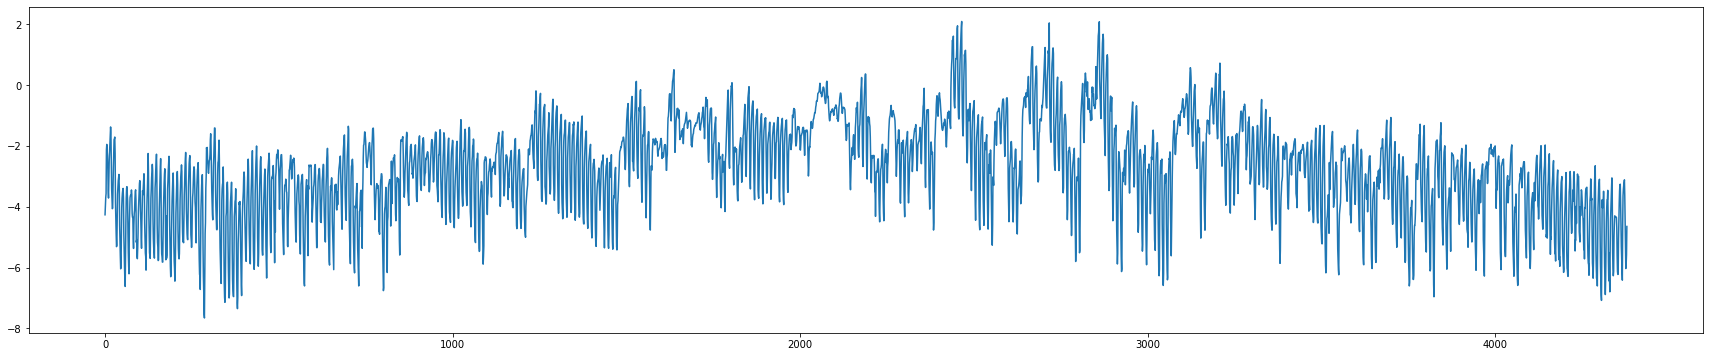

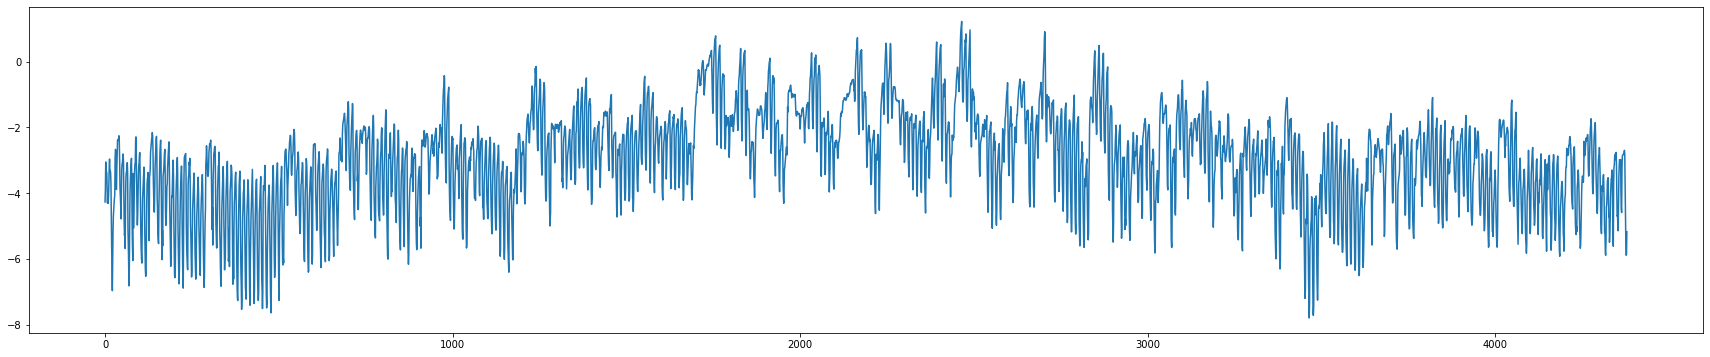

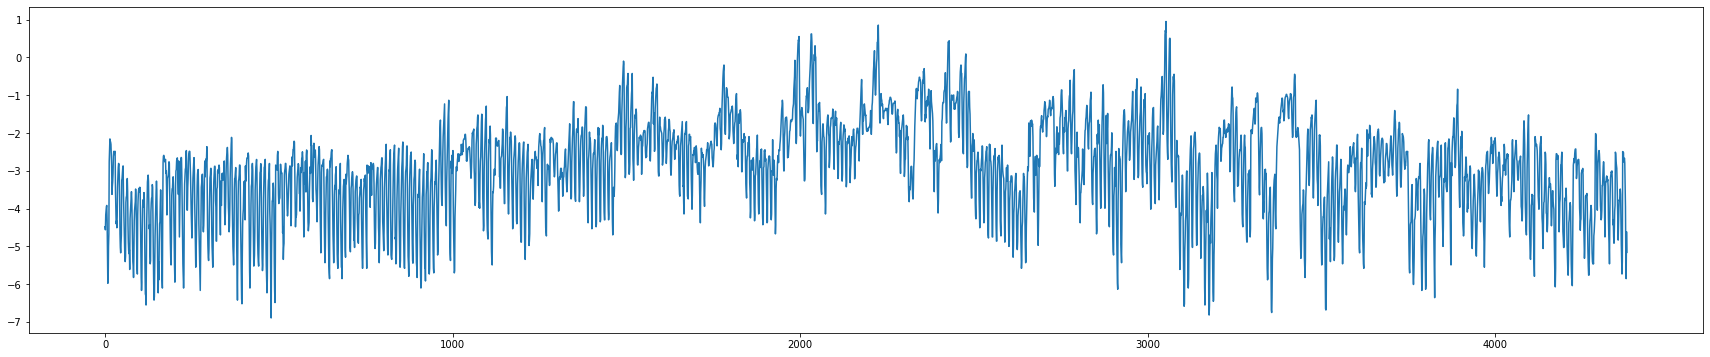

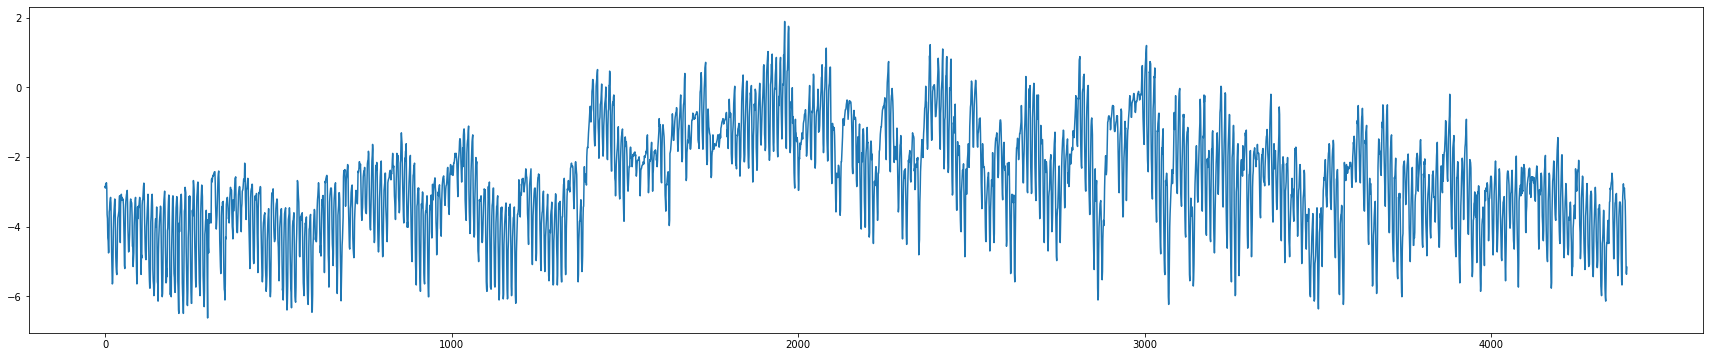

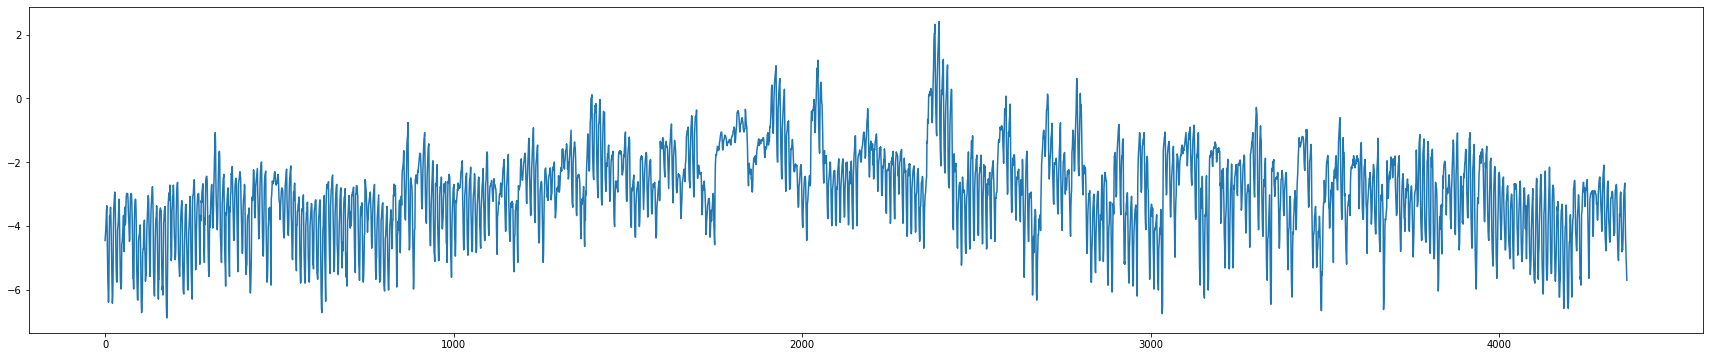

In [ ]:
plt.figure(figsize= (30,6))
plt.plot(y_pred2009-Temperatura2009)
print('2009')
print('\nMáxima diferencia: ', max(np.abs(y_pred2009-np.reshape(Temperatura2009, [-1,1]))), ', Media: ', np.mean(y_pred2009-np.reshape(Temperatura2009, [-1,1])))
plt.figure(figsize= (30,6))
plt.plot(y_pred2010-Temperatura2010)
print('2010')
print('\nMáxima diferencia: ', max(np.abs(y_pred2010-np.reshape(Temperatura2010, [-1,1]))), ', Media: ', np.mean(y_pred2010-np.reshape(Temperatura2010, [-1,1])))
plt.figure(figsize= (30,6))
plt.plot(y_pred2011-Temperatura2011)
print('2011')
print('\nMáxima diferencia: ', max(np.abs(y_pred2011-np.reshape(Temperatura2011, [-1,1]))), ', Media: ', np.mean(y_pred2011-np.reshape(Temperatura2011, [-1,1])))
plt.figure(figsize= (30,6))
plt.plot(y_pred2012-Temperatura2012)
print('2012')
print('\nMáxima diferencia: ', max(np.abs(y_pred2012-np.reshape(Temperatura2012, [-1,1]))), ', Media: ', np.mean(y_pred2012-np.reshape(Temperatura2012, [-1,1])))
plt.figure(figsize= (30,6))
plt.plot(y_pred2013-Temperatura2013)
print('2013')
print('\nMáxima diferencia: ', max(np.abs(y_pred2013-np.reshape(Temperatura2013, [-1,1]))), ', Media: ', np.mean(y_pred2013-np.reshape(Temperatura2013, [-1,1])))
plt.figure(figsize= (30,6))
plt.plot(y_pred2014-Temperatura2014)
print('2014')
print('\nMáxima diferencia: ', max(np.abs(y_pred2014-np.reshape(Temperatura2014, [-1,1]))), ', Media: ', np.mean(y_pred2014-np.reshape(Temperatura2014, [-1,1])))
plt.figure(figsize= (30,6))
plt.plot(y_pred2015-Temperatura2015)
print('2015')
print('\nMáxima diferencia: ', max(np.abs(y_pred2015-np.reshape(Temperatura2015, [-1,1]))), ', Media: ', np.mean(y_pred2015-np.reshape(Temperatura2015, [-1,1])))
plt.figure(figsize= (30,6))
plt.plot(y_pred2016-Temperatura2016)
print('2016')
print('\nMáxima diferencia: ', max(np.abs(y_pred2016-np.reshape(Temperatura2016, [-1,1]))), ', Media: ', np.mean(y_pred2016-np.reshape(Temperatura2016, [-1,1])))
plt.figure(figsize= (30,6))
plt.plot(y_pred2017-Temperatura2017)
print('2017')
print('\nMáxima diferencia: ', max(np.abs(y_pred2017-np.reshape(Temperatura2017, [-1,1]))), ', Media: ', np.mean(y_pred2017-np.reshape(Temperatura2017, [-1,1])))

In [ ]:
df

,Temperatura Asuncion,Dia,Mes,Año,Hora,temp_t1,Year_t1,Hour_t1,Month_t1,Weekday_t1
date,,,,,,,,,,
2009-01-08 00:00:00,26.769231,8,1,2009,0,24.215385,2009.0,2.0,1.0,8.0
2009-01-08 02:00:00,24.215385,8,1,2009,2,23.007692,2009.0,4.0,1.0,8.0
2009-01-08 04:00:00,23.007692,8,1,2009,4,21.738462,2009.0,6.0,1.0,8.0
2009-01-08 06:00:00,21.738462,8,1,2009,6,20.692308,2009.0,8.0,1.0,8.0
2009-01-08 08:00:00,20.692308,8,1,2009,8,24.053846,2009.0,10.0,1.0,8.0
...,...,...,...,...,...,...,...,...,...,...
2017-12-30 12:00:00,29.900000,30,12,2017,12,31.500000,2017.0,14.0,12.0,30.0
2017-12-30 14:00:00,31.500000,30,12,2017,14,32.900000,2017.0,16.0,12.0,30.0
2017-12-30 16:00:00,32.900000,30,12,2017,16,34.000000,2017.0,18.0,12.0,30.0


In [ ]:
#aux=np.zeros((372,12)
#for i in range(1,13):
#  aux[:,i]= df.loc[(df['Año']==2009) & (df['Mes']==i), "Temperatura Asuncion"].values


In [ ]:
TemperaturaEnero2016= df.loc[(df['Año']==2016) & (df['Mes']==1), "Temperatura Asuncion"].values
print(len(TemperaturaEnero2016))
TemperaturaFebrero2016= df.loc[(df['Año']==2016) & (df['Mes']==2), "Temperatura Asuncion"].values
print(len(TemperaturaFebrero2016))
TemperaturaMarzo2016= df.loc[(df['Año']==2016) & (df['Mes']==3), "Temperatura Asuncion"].values
print(len(TemperaturaMarzo2016))
TemperaturaAbril2016= df.loc[(df['Año']==2016) & (df['Mes']==4), "Temperatura Asuncion"].values
print(len(TemperaturaAbril2016))
TemperaturaMayo2016= df.loc[(df['Año']==2016) & (df['Mes']==5), "Temperatura Asuncion"].values
print(len(TemperaturaMayo2016))
TemperaturaJunio2016= df.loc[(df['Año']==2016) & (df['Mes']==6), "Temperatura Asuncion"].values
print(len(TemperaturaJunio2016))
TemperaturaJulio2016= df.loc[(df['Año']==2016) & (df['Mes']==7), "Temperatura Asuncion"].values
print(len(TemperaturaJulio2016))
TemperaturaAgosto2016= df.loc[(df['Año']==2016) & (df['Mes']==8), "Temperatura Asuncion"].values
print(len(TemperaturaAgosto2016))
TemperaturaSeptiembre2016= df.loc[(df['Año']==2016) & (df['Mes']==9), "Temperatura Asuncion"].values
print(len(TemperaturaSeptiembre2016))
TemperaturaOctubre2016= df.loc[(df['Año']==2016) & (df['Mes']==10), "Temperatura Asuncion"].values
print(len(TemperaturaOctubre2016))
TemperaturaNoviembre2016= df.loc[(df['Año']==2016) & (df['Mes']==11), "Temperatura Asuncion"].values
print(len(TemperaturaNoviembre2016))
TemperaturaDiciembre2016= df.loc[(df['Año']==2016) & (df['Mes']==12), "Temperatura Asuncion"].values
print(len(TemperaturaDiciembre2016))
TemperaturaJunio2016 = np.reshape(TemperaturaJunio2016, [-1,1])

TemperaturaDiciembre2016 = np.reshape(TemperaturaDiciembre2016, [-1,1])
y_predJunio2016 = scaler.inverse_transform(model.predict(TemperaturaJunio2016))
y_predDiciembre2016 = scaler.inverse_transform(model.predict(TemperaturaDiciembre2016))
TemperaturaJunio2016=scaler.inverse_transform(np.reshape(TemperaturaJunio2016, [-1,1]))
TemperaturaDiciembre2016=scaler.inverse_transform(np.reshape(TemperaturaDiciembre2016, [-1,1]))

372
348
372
360
372
360
372
372
360
372
360
372


In [ ]:
TemperaturaJunio2009= df.loc[(df['Año']==2009) & (df['Mes']==6), "Temperatura Asuncion"].values
TemperaturaDiciembre2009= df.loc[(df['Año']==2009) & (df['Mes']==12), "Temperatura Asuncion"].values
TemperaturaJunio2009 = np.reshape(TemperaturaJunio2009, [-1,1])
TemperaturaDiciembre2009 = np.reshape(TemperaturaDiciembre2009, [-1,1])
y_predJunio2009 = scaler.inverse_transform(model.predict(TemperaturaJunio2009))
y_predDiciembre2009 = scaler.inverse_transform(model.predict(TemperaturaDiciembre2009))
TemperaturaJunio2009=scaler.inverse_transform(np.reshape(TemperaturaJunio2009, [-1,1]))
TemperaturaDiciembre2009=scaler.inverse_transform(np.reshape(TemperaturaDiciembre2009, [-1,1]))

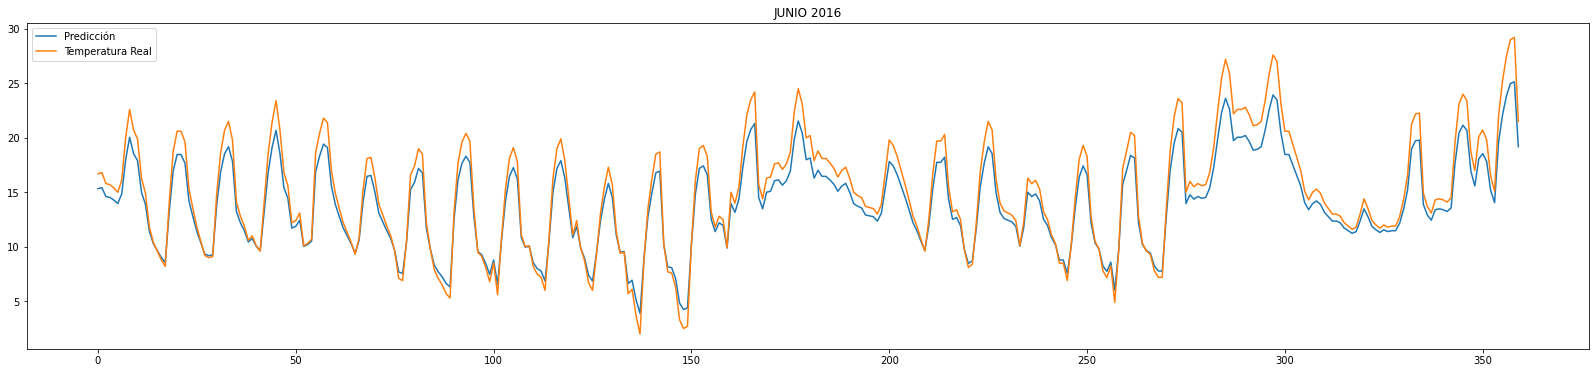

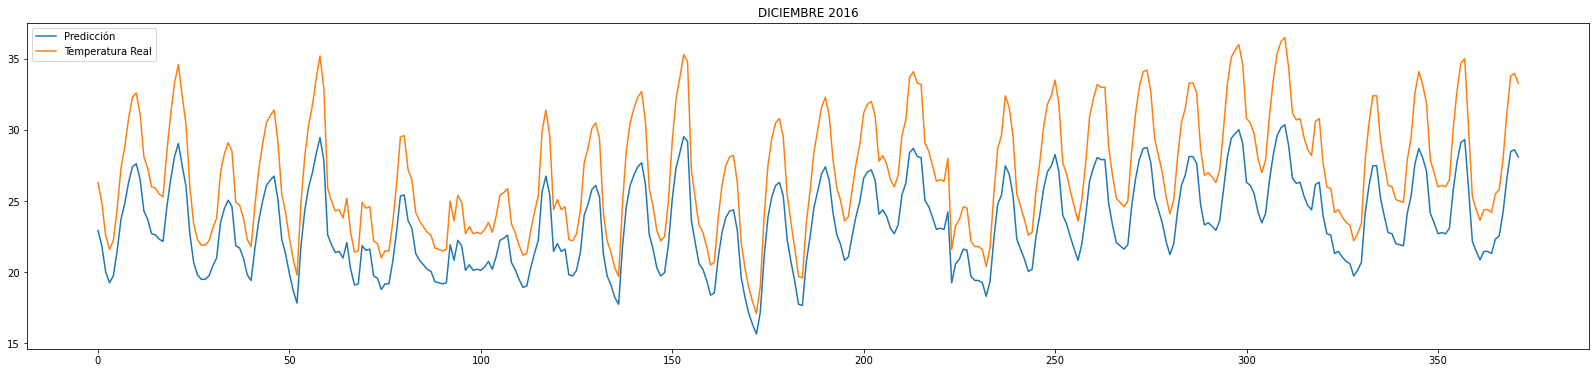

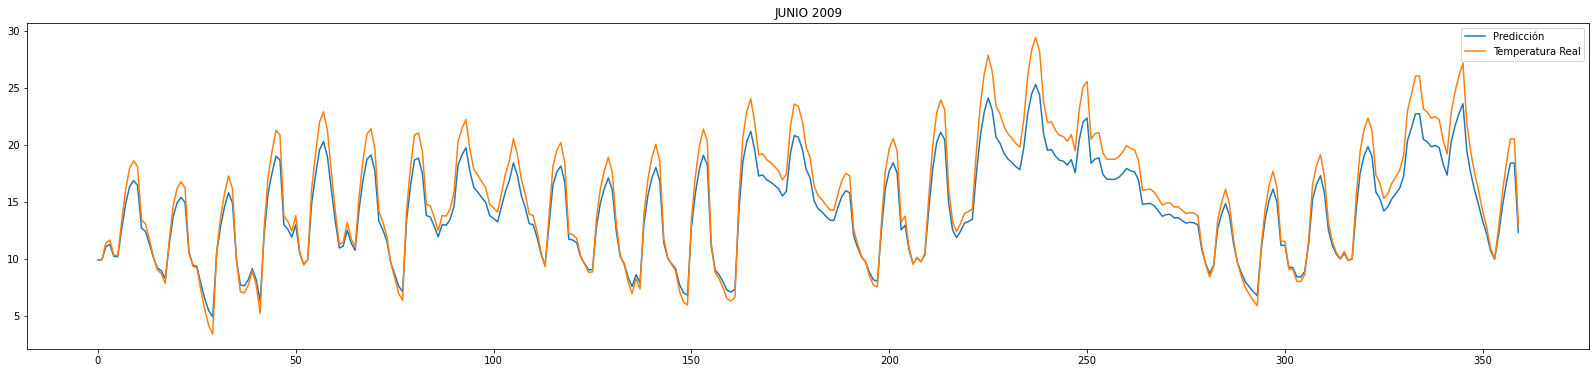

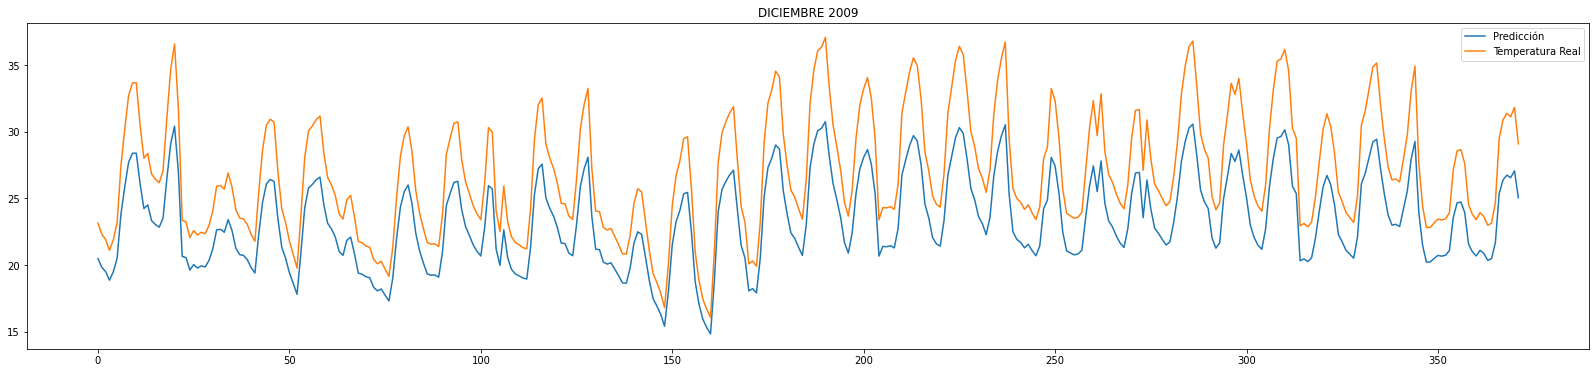

In [ ]:
plt.figure(figsize= (28,6))
plt.title('JUNIO 2016')
plt.plot(y_predJunio2016, label='Predicción')
plt.plot(TemperaturaJunio2016, label='Temperatura Real')
plt.legend()
plt.show()
plt.figure(figsize= (28,6))
plt.title('DICIEMBRE 2016')
plt.plot(y_predDiciembre2016, label='Predicción')
plt.plot(TemperaturaDiciembre2016, label='Temperatura Real')
plt.legend()
plt.show()
plt.figure(figsize= (28,6))
plt.title('JUNIO 2009')
plt.plot(y_predJunio2009, label='Predicción')
plt.plot(TemperaturaJunio2009, label='Temperatura Real')
plt.legend()
plt.show()
plt.figure(figsize= (28,6))
plt.title('DICIEMBRE 2009')
plt.plot(y_predDiciembre2009, label='Predicción')
plt.plot(TemperaturaDiciembre2009, label='Temperatura Real')
plt.legend()
plt.show()

In [ ]:
print('\nMáxima diferencia JUNIO 2009: ', max(np.abs(y_predJunio2009-np.reshape(TemperaturaJunio2009, [-1,1]))), ', Media: ', np.mean(y_predJunio2009-np.reshape(TemperaturaJunio2009, [-1,1])))
print('\nMáxima diferencia JUNIO 2016: ', max(np.abs(y_predJunio2016-np.reshape(TemperaturaJunio2016, [-1,1]))), ', Media: ', np.mean(y_predJunio2016-np.reshape(TemperaturaJunio2016, [-1,1])))


Máxima diferencia JUNIO 2009:  [4.12355455] , Media:  -1.1348278710169646

Máxima diferencia JUNIO 2016:  [4.06894226] , Media:  -1.016876116268809


In [ ]:
print('\nMáxima diferencia DICIEMBRE 2016: ', max(np.abs(y_predDiciembre2009-np.reshape(TemperaturaDiciembre2009, [-1,1]))), ', Media: ', np.mean(y_predDiciembre2009-np.reshape(TemperaturaDiciembre2009, [-1,1])))
print('\nMáxima diferencia DICIEMBRE 2016: ', max(np.abs(y_predDiciembre2016-np.reshape(TemperaturaDiciembre2016, [-1,1]))), ', Media: ', np.mean(y_predDiciembre2016-np.reshape(TemperaturaDiciembre2016, [-1,1])))



Máxima diferencia DICIEMBRE 2016:  [6.32519115] , Media:  -3.5848079817082623

Máxima diferencia DICIEMBRE 2016:  [6.13665962] , Media:  -3.5849232095953583


In [ ]:
Temp2009=pd.DataFrame(df[(df['Mes'] == 12) & (df['Año'] == 2009)]['Temperatura Asuncion'].values)#df[df['Año'] == 2009]
Temp2009['Enero']=np.resize(df[(df['Mes'] == 1) & (df['Año'] == 2009)]['Temperatura Asuncion'].values,(372,1))
Temp2009.drop(columns=0,inplace=True)
Temp2009['Febrero']=np.resize(df[(df['Mes'] == 2) & (df['Año'] == 2009)]['Temperatura Asuncion'].values,(372,1))
#Temp2009['Marzo']=df[(df['Mes'] == 3) & (df['Año'] == 2009)]['Temperatura Asuncion']
#Temp2009['Enero']=df[(df['Mes'] == 1) & (df['Año'] == 2009)]['Temperatura Asuncion']
Temp2009

,Enero,Febrero
0,26.769231,27.538462
1,24.215385,24.946154
2,23.007692,23.223077
3,21.738462,21.861538
4,20.692308,21.284615
...,...,...
367,32.823077,29.953846
368,35.923077,31.600000
369,37.653846,33.046154
370,26.884615,23.376923


In [ ]:
np.resize(df[(df['Mes'] == 1) & (df['Año'] == 2009)]['Temperatura Asuncion'].values,(1,372))

array([[26.76923077, 24.21538462, 23.00769231, 21.73846154, 20.69230769,
        24.05384615, 32.76153846, 32.35384615, 34.25384615, 35.65384615,
        28.70769231, 28.36153846, 25.46923077, 23.25384615, 21.69230769,
        20.66153846, 20.57692308, 21.68461538, 24.65384615, 27.5       ,
        30.3       , 26.52307692, 26.20769231, 24.96153846, 23.34615385,
        22.56153846, 20.93846154, 20.80769231, 19.46153846, 21.04615385,
        25.33846154, 26.50769231, 28.56923077, 29.58461538, 31.39230769,
        29.94615385, 25.15384615, 24.83076923, 22.43076923, 21.50769231,
        20.53076923, 22.45384615, 29.13076923, 32.86923077, 35.08461538,
        36.19230769, 36.01538462, 33.57692308, 27.83076923, 27.70769231,
        26.50769231, 25.05384615, 24.97692308, 26.99230769, 29.03076923,
        33.04615385, 35.44615385, 29.63846154, 29.74615385, 29.9       ,
        22.3       , 21.43076923, 22.3       , 22.06153846, 21.78461538,
        21.83076923, 27.15384615, 30.7       , 32.2